<a href="https://www.kaggle.com/code/katecaldwell/classify-reddit-post-titles-w-feature-extraction?scriptVersionId=96780476" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classifying Titles with Feature Extraction from Transformers

In this notebook, I classify Reddit post titles into 'Conservative' or 'Liberal' posts. To accomplish this, I extract hidden representations of the data from a pretrained model (downloaded from HuggingFace), which I then use in a simple deep network to classify the titles.

The data can be found [here](http://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts).

I referenced many materials to complete this and related notebooks, including [*Deep Learning with Python*](http://https://www.manning.com/books/deep-learning-with-python) by François Chollet and [*Natural Language Processing with Transformers*](http://https://www.oreilly.com/library/view/natural-language-processing/9781098103231/) by Lewis Tunstall, Leandro von Werra, Thomas Wolf.

In [1]:
# imports and installs

import numpy as np
import pandas as pd
        
!pip install -U transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.3 requires transformers<4.19,>=4.1, but you have transformers 4.19.2 which is incompatible.


In [2]:
# load data into HuggingFace dataset

from datasets import load_dataset
dataset = load_dataset('csv', data_files='../input/liberals-vs-conservatives-on-reddit-13000-posts/file_name.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fc9590c0949f0926/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# change format to pandas dataframe to prepare data
# shuffle the data, drop irrelevant columns, 

dataset.set_format(type="pandas")
df = dataset["train"][:]
df = df.drop(columns=['Score', 'Id', 'Subreddit', 'URL', 'Num of Comments','Date Created', 'Text'])
df.sample(frac=1)


,Title,Political Lean
8423,The draft is slavery. I didn't think I needed ...,Conservative
5116,This is Starbucks latest union busting campaig...,Liberal
7031,"TPUSA is launching an ""America-first education...",Liberal
5851,Merrick Garland,Liberal
649,Photo of Socialist Cuba. Man in a straw hat wi...,Liberal
...,...,...
8478,Almost 1 MILLION people waitlisted for Truth S...,Conservative
235,Destabilizing Russia is the U.S. empire’s only...,Liberal
1862,Proposal: Independently Redefine Poverty Standard,Liberal
6515,The For The People Act gets voted on next week...,Liberal


In [4]:
# encode labels

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df["Political Lean"])
df["Political Lean"] = le.transform(df["Political Lean"])

In [5]:
# convert back into HuggingFace dataset

from datasets import Dataset

politics = Dataset.from_pandas(df)
politics

Dataset({
    features: ['Title', 'Political Lean'],
    num_rows: 12854
})

In [6]:
# split the data into 90% train, 5% val, and 5% test
train_test = politics.train_test_split(test_size=0.1)
test_valid = train_test['test'].train_test_split(test_size=0.5)

# gather splits into single dataset
from datasets import DatasetDict
politics = DatasetDict({
    'train': train_test['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
#politics = politics.remove_columns(['__index_level_0__'])
politics

DatasetDict({
    train: Dataset({
        features: ['Title', 'Political Lean'],
        num_rows: 11568
    })
    test: Dataset({
        features: ['Title', 'Political Lean'],
        num_rows: 643
    })
    valid: Dataset({
        features: ['Title', 'Political Lean'],
        num_rows: 643
    })
})

In [7]:
# tokenizing the text from pretrained model

from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [8]:
# tokenize all data

def tokenize(batch):
    return tokenizer(batch["Title"], padding=True, truncation=True)

politics_encoded = politics.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
# download and instantiate model

from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt)
model = model.to("cuda")

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# define function to extract hidden states from model for data

import torch

def extract_hidden_states(batch):
    inputs = {key: batch[key].to("cuda") for key in ["input_ids", "attention_mask"]}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].detach().cpu().numpy()}

In [11]:
# convert tokenized text into pytorch tensors

politics_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "Political Lean"])

In [12]:
# extract hidden states from model for all data
# look at hidden state tensor

politics_hidden = politics_encoded.map(extract_hidden_states, batched=True, batch_size=1)
politics_hidden["train"][1]

  0%|          | 0/11568 [00:00<?, ?ba/s]

  0%|          | 0/643 [00:00<?, ?ba/s]

  0%|          | 0/643 [00:00<?, ?ba/s]

{'Political Lean': tensor(1),
 'input_ids': tensor([  101,  2104, 16498,  2065,  2017,  3426,  1037,  2543,  2008,  8563,
          5606,  2017,  2097,  2022, 14610,  2007,  4895,  9581, 20876,  3468,
          7177,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0

In [13]:
# convert data to numpy arrays 

import numpy as np

X_train = np.array(politics_hidden["train"]["hidden_state"])
X_valid = np.array(politics_hidden["valid"]["hidden_state"])
y_train = np.array(politics_hidden["train"]["Political Lean"])
y_valid = np.array(politics_hidden["valid"]["Political Lean"])
X_test = np.array(politics_hidden["test"]["hidden_state"])
y_test = np.array(politics_hidden["test"]["Political Lean"])
X_train.shape, X_valid.shape

((11568, 768), (643, 768))

In [14]:
# using hidden states, train on simple dense network

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

2022-05-27 19:39:37.319035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:39:37.320194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:39:37.320858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:39:37.321658: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
# train network

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_valid, y_valid))

2022-05-27 19:39:37.987800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
23/23 [==============================] - 1s 12ms/step - loss: 0.6632 - accuracy: 0.6316 - val_loss: 0.6017 - val_accuracy: 0.6610
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6677 - val_loss: 0.6062 - val_accuracy: 0.6594
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.6770 - val_loss: 0.5697 - val_accuracy: 0.6998
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5867 - accuracy: 0.6850 - val_loss: 0.5804 - val_accuracy: 0.6781
Epoch 5/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5824 - accuracy: 0.6877 - val_loss: 0.5708 - val_accuracy: 0.6843
Epoch 6/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5775 - accuracy: 0.6897 - val_loss: 0.5885 - val_accuracy: 0.6687
Epoch 7/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5718 - accuracy: 0.6973 - val_loss: 0.5454 - val_accuracy: 0.7247
Epoch 8/20
23/23 [=

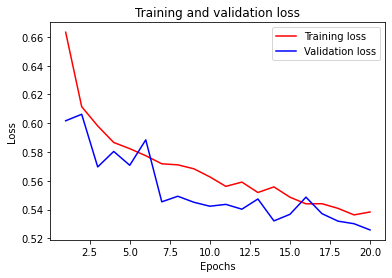

In [16]:
# plot loss over epochs

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss") # "b--" is for "blue dashed line"
plt.plot(epochs, val_loss_values, "b", label="Validation loss") # b is for "solid blue line"
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
# get test metrics

from sklearn import metrics

preds = model(X_test)
preds = preds.numpy()
preds = preds>0.5

print("Accuracy is", metrics.accuracy_score(y_test, preds))
print("F1 score is", metrics.f1_score(y_test, preds))
print("Precision is", metrics.precision_score(y_test, preds))
print("Recall is", metrics.recall_score(y_test, preds))


Accuracy is 0.6734059097978227
F1 score is 0.7803347280334729
Precision is 0.6757246376811594
Recall is 0.9232673267326733


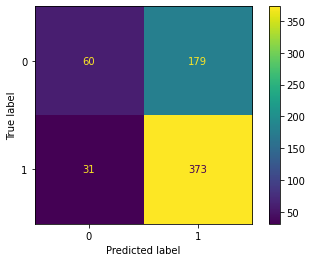

In [18]:
# looking at the confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

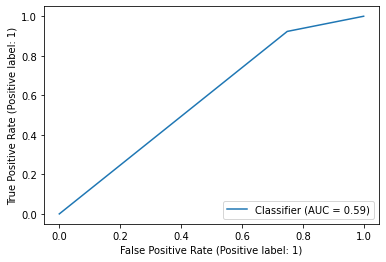

In [19]:
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, preds)